<a href="https://colab.research.google.com/github/UjjwalPardeshi/xai/blob/main/xai_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade numpy torch torchvision captum transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


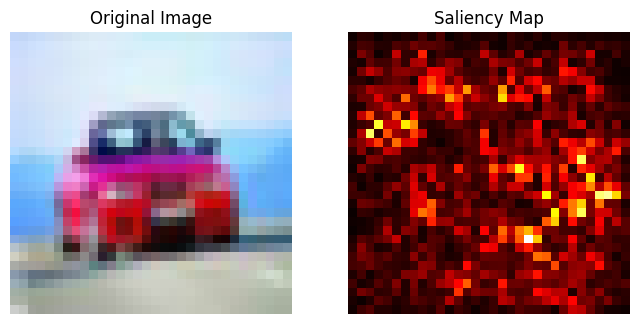

Template explanation: The model predicted a automobile with attention on the bottom and right of the image.


Device set to use cuda:0


Refined explanation: Das Modell prezidierte eine automobile mit Aufmerksamkeit auf der unteren und rechts der image.


In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
from captum.attr import Saliency
import matplotlib.pyplot as plt
from transformers import pipeline

# Load CIFAR-10 test set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)
classes = testset.classes

# Load pretrained ResNet20 from CIFAR-10 PyTorch Hub
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('chenyaofo/pytorch-cifar-models', 'cifar10_resnet20', pretrained=True)
model = model.to(device)
model.eval()

# Get a test image and label
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)
output = model(images)
pred_class = output.argmax(1).item()
pred_label = classes[pred_class]

# Saliency attribution
images.requires_grad_()
saliency = Saliency(model)
attributions = saliency.attribute(images, target=pred_class)
attributions = attributions.detach().cpu().numpy()[0].transpose(1,2,0)

# Show image and saliency map, with correct tensor conversion!
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
denorm = lambda t: (t * torch.tensor((0.2023, 0.1994, 0.2010))[:,None,None] + torch.tensor((0.4914, 0.4822, 0.4465))[:,None,None])
img_to_show = denorm(images[0].detach().cpu()).permute(1,2,0).clamp(0,1) # Key fix: .detach() here
plt.imshow(img_to_show)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(attributions.sum(axis=2), cmap='hot')
plt.title('Saliency Map')
plt.axis('off')
plt.show()

# Attribution to natural language template
def attribution_to_text(saliency_map, label, threshold=0.5):
    S = saliency_map.sum(axis=2)
    h, w = S.shape
    region = []
    if S[:h//2].sum() > threshold * S.sum(): region.append('top')
    if S[h//2:].sum() > threshold * S.sum(): region.append('bottom')
    if S[:,:w//2].sum() > threshold * S.sum(): region.append('left')
    if S[:,w//2:].sum() > threshold * S.sum(): region.append('right')
    region_str = ' and '.join(region) if region else 'various regions'
    return f"The model predicted a {label} with attention on the {region_str} of the image."

explanation = attribution_to_text(attributions, pred_label)
print("Template explanation:", explanation)

# Refine with language model
paraphraser = pipeline("text2text-generation", model="t5-small")
refined_explanation = paraphraser(explanation)[0]['generated_text']
print("Refined explanation:", refined_explanation)


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar100_resnet20-23dac2f1.pt" to /root/.cache/torch/hub/checkpoints/cifar100_resnet20-23dac2f1.pt


100%|██████████| 1.11M/1.11M [00:00<00:00, 5.52MB/s]


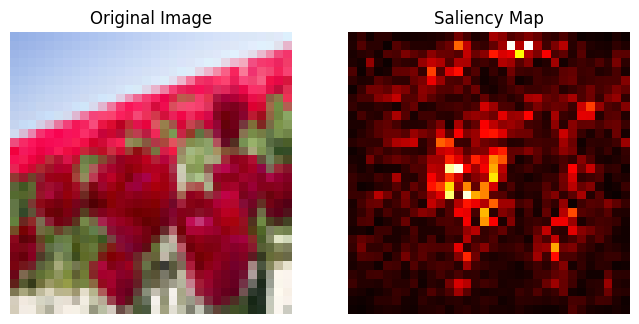

Template explanation: The model predicted a rose with attention on the top and left of the image.


Device set to use cuda:0


Refined explanation: Das Modell rechnete mit einer rose, mit Aufmerksamkeit auf oben und links der image.


In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from captum.attr import Saliency
import matplotlib.pyplot as plt
from transformers import pipeline

# Load CIFAR-100 test set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)
classes = testset.classes

# Load pretrained ResNet20 from CIFAR-100 PyTorch Hub
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('chenyaofo/pytorch-cifar-models', 'cifar100_resnet20', pretrained=True)
model = model.to(device)
model.eval()

# Get a test image and label
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)
output = model(images)
pred_class = output.argmax(1).item()
pred_label = classes[pred_class]

# Saliency attribution
images.requires_grad_()
saliency = Saliency(model)
attributions = saliency.attribute(images, target=pred_class)
attributions = attributions.detach().cpu().numpy()[0].transpose(1,2,0)

# Show image and saliency map, with correct tensor conversion!
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
denorm = lambda t: (t * torch.tensor((0.2673, 0.2564, 0.2761))[:,None,None] + torch.tensor((0.5071, 0.4865, 0.4409))[:,None,None])
img_to_show = denorm(images[0].detach().cpu()).permute(1,2,0).clamp(0,1)
plt.imshow(img_to_show)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(attributions.sum(axis=2), cmap='hot')
plt.title('Saliency Map')
plt.axis('off')
plt.show()

# Attribution to natural language template
def attribution_to_text(saliency_map, label, threshold=0.5):
    S = saliency_map.sum(axis=2)
    h, w = S.shape
    region = []
    if S[:h//2].sum() > threshold * S.sum(): region.append('top')
    if S[h//2:].sum() > threshold * S.sum(): region.append('bottom')
    if S[:,:w//2].sum() > threshold * S.sum(): region.append('left')
    if S[:,w//2:].sum() > threshold * S.sum(): region.append('right')
    region_str = ' and '.join(region) if region else 'various regions'
    return f"The model predicted a {label} with attention on the {region_str} of the image."

explanation = attribution_to_text(attributions, pred_label)
print("Template explanation:", explanation)

# Refine with language model
paraphraser = pipeline("text2text-generation", model="t5-small")
refined_explanation = paraphraser(explanation)[0]['generated_text']
print("Refined explanation:", refined_explanation)


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from transformers import pipeline
import numpy as np

# Data transforms (mean/std for CIFAR-10)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Datasets and loaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
classes = trainset.classes

# Device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('chenyaofo/pytorch-cifar-models', 'cifar10_repvgg_a2', pretrained=True)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)

num_epochs = 20  # Increase for stronger results (100–200 for publications)
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_acc = 0.0
best_model = None

# Training/validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        running_correct += predicted.eq(targets).sum().item()
        total += targets.size(0)
    train_losses.append(running_loss / total)
    train_accs.append(running_correct / total)

    # Validation
    model.eval()
    running_loss, running_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            running_correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
    val_losses.append(running_loss / total)
    val_acc = running_correct / total
    val_accs.append(val_acc)

    # Save best
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = model.state_dict()
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_accs[-1]:.4f}")

print(f"\nBest validation accuracy: {best_acc*100:.2f}%")

# Save model
torch.save(best_model, "cifar10_repvgg_a2_best.pth")


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/repvgg/cifar10_repvgg_a2-09488915.pt" to /root/.cache/torch/hub/checkpoints/cifar10_repvgg_a2-09488915.pt


100%|██████████| 103M/103M [00:03<00:00, 31.1MB/s]


Epoch 1/20 | Train Acc: 0.9688 | Val Acc: 0.8725
Epoch 2/20 | Train Acc: 0.9611 | Val Acc: 0.8786
Epoch 3/20 | Train Acc: 0.9695 | Val Acc: 0.9100
Epoch 4/20 | Train Acc: 0.9734 | Val Acc: 0.8932
Epoch 5/20 | Train Acc: 0.9761 | Val Acc: 0.9074
Epoch 6/20 | Train Acc: 0.9781 | Val Acc: 0.9021
Epoch 7/20 | Train Acc: 0.9800 | Val Acc: 0.9113
Epoch 8/20 | Train Acc: 0.9815 | Val Acc: 0.9005
Epoch 9/20 | Train Acc: 0.9819 | Val Acc: 0.9187
Epoch 10/20 | Train Acc: 0.9830 | Val Acc: 0.9174
Epoch 11/20 | Train Acc: 0.9849 | Val Acc: 0.9118
Epoch 12/20 | Train Acc: 0.9838 | Val Acc: 0.9224
Epoch 13/20 | Train Acc: 0.9836 | Val Acc: 0.9159
Epoch 14/20 | Train Acc: 0.9841 | Val Acc: 0.9201
Epoch 15/20 | Train Acc: 0.9843 | Val Acc: 0.9237
Epoch 16/20 | Train Acc: 0.9836 | Val Acc: 0.9233
Epoch 17/20 | Train Acc: 0.9860 | Val Acc: 0.9105
Epoch 18/20 | Train Acc: 0.9852 | Val Acc: 0.9189
Epoch 19/20 | Train Acc: 0.9870 | Val Acc: 0.9248
Epoch 20/20 | Train Acc: 0.9846 | Val Acc: 0.9117

Best val

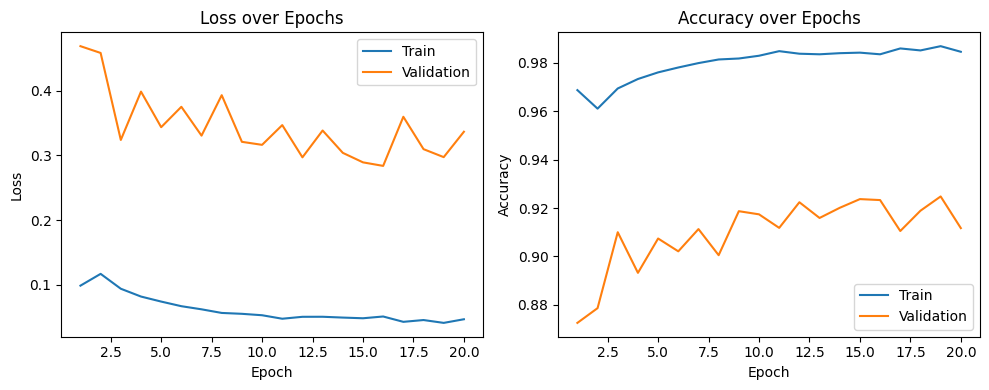

In [11]:
epochs = range(1, num_epochs+1)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train")
plt.plot(epochs, val_losses, label="Validation")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label="Train")
plt.plot(epochs, val_accs, label="Validation")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


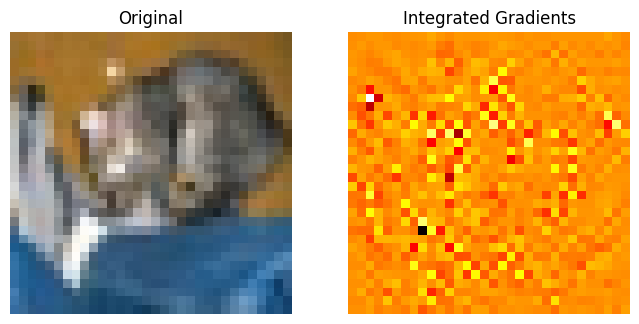

Template explanation: The model predicted a cat with attention on the top and left of the image.


Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=48) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Refined explanation: False


In [13]:
# Load best model for explainability
model.load_state_dict(torch.load("/content/cifar10_repvgg_a2_best.pth"))
model.eval()

testiter = iter(testloader)
images, labels = next(testiter)
image = images[0:1].to(device)
label = labels[0].item()
pred = model(image).argmax(1).item()
pred_label = classes[pred]

# Integrated Gradients attribution
image.requires_grad_()
ig = IntegratedGradients(model)
attr = ig.attribute(image, target=pred, n_steps=50)
attr = attr.detach().cpu().numpy()[0].transpose(1,2,0)

# Visualize
plt.figure(figsize=(8,4))
denorm = lambda t: (t * torch.tensor((0.2023, 0.1994, 0.2010))[:,None,None] + torch.tensor((0.4914, 0.4822, 0.4465))[:,None,None])
img_to_show = denorm(image[0].detach().cpu()).permute(1,2,0).clamp(0,1)
plt.subplot(1,2,1)
plt.imshow(img_to_show)
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(attr.sum(axis=2), cmap='hot')
plt.title('Integrated Gradients')
plt.axis('off')
plt.show()

# Explanation
def attribution_to_text(saliency_map, label, threshold=0.5):
    S = saliency_map.sum(axis=2)
    h, w = S.shape
    region = []
    if S[:h//2].sum() > threshold * S.sum(): region.append('top')
    if S[h//2:].sum() > threshold * S.sum(): region.append('bottom')
    if S[:,:w//2].sum() > threshold * S.sum(): region.append('left')
    if S[:,w//2:].sum() > threshold * S.sum(): region.append('right')
    region_str = ' and '.join(region) if region else 'various regions'
    article = 'an' if label[0].lower() in 'aeiou' else 'a'
    return f"The model predicted {article} {label} with attention on the {region_str} of the image."

expl = attribution_to_text(attr, pred_label)
print("Template explanation:", expl)

paraphraser = pipeline("text2text-generation", model="t5-small")
refined_expl = paraphraser("paraphrase: " + expl, max_length=48)[0]['generated_text']
print("Refined explanation:", refined_expl)


In [17]:
import torch
import torchvision
import torchvision.transforms as transforms

# --- 1. CIFAR-10 TESTSET & TESTLOADER (already defined above, but repeat here for completeness) ---
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
classes = testset.classes

# --- 2. Load the model structure and weights ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('chenyaofo/pytorch-cifar-models', 'cifar10_repvgg_a2', pretrained=False)
model.load_state_dict(torch.load("./cifar10_repvgg_a2_best.pth", map_location=device))
model = model.to(device)
model.eval()

# --- 3. Evaluate test accuracy ---
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Test accuracy: 91.17%


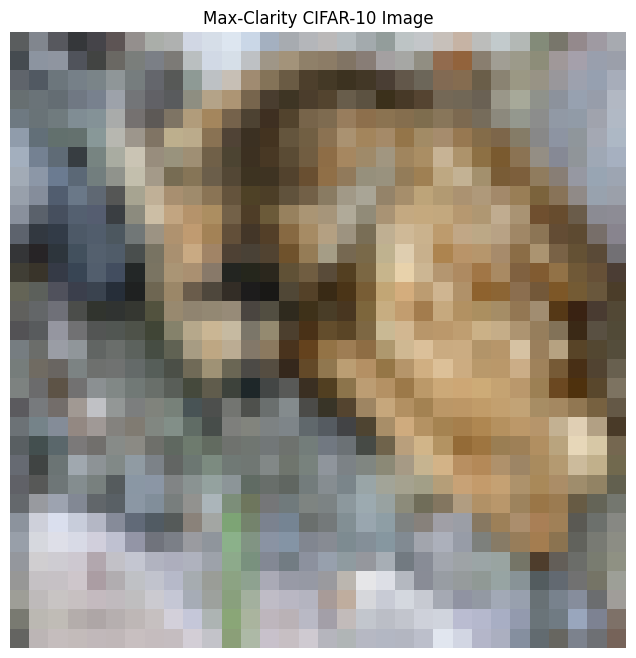

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assume image[0] is your CHW tensor, normalized
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])

img = image[0].detach().cpu().numpy()
img = (img * std[:, None, None]) + mean[:, None, None]
img = np.clip(img, 0, 1)
img = np.transpose(img, (1, 2, 0))

plt.figure(figsize=(8,8))                 # Large display
plt.imshow(img, interpolation='nearest')
plt.title('Max-Clarity CIFAR-10 Image')
plt.axis('off')
plt.show()
